# HFRX Global Hedge Fund Index Replication
by Doldi Filippo, Nodari Alessandro, Prosepio Lorenzo, Venturi Simone

We tried to replicate and forecast the HFRX Global Hedge Fund Index using only a dynamic portfolio made of 11 futures. In particolar we used the followings futures (tickers only): RX1, TY1, GC1, CO1, ES1, VG1, NQ1, LLL1, TP1, DU1, TU2.

### Loading the libraries and the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pykalman as pk

data = pd.read_excel("InvestmentReplica.xlsx", sheet_name="Replica")
data.set_index('Date', inplace = True)

#Futures
df = pd.DataFrame(np.log(data.iloc[:,4:]).diff(1).dropna())

#Index, our target
target = data['HFRXGL']
targetR = pd.DataFrame(np.log(data['HFRXGL']).diff(1).dropna())
targetR.rename(columns = {'HFRXGL' : 'return'}, inplace = True)

## Replication approach: Kalman filter

We have one observable variable, i.e. target portolio return, which is a function of:
1. an unobservable variable, the vector of weights;
2. an observable variable, the vector of (candidate) asset returns.

Set:
- $r^{ind}_t$ = target return from t-1 to t (scalar);
- $\textbf{w}_t$ = unknown weights (vector NumberOfAsset x 1)

We can represent this using the following State-Space Model:
        $$\textbf{w}_t=A\textbf{w}_{t-1}+\mathcal{N}(0,Q)$$
        $$r^{ind}_t=\textbf{r}_t\textbf{w}_t+\mathcal{N}(0,R)$$
where (reasonably):
- $A$ = identity matrix, i.e. weight(i,t) = weight(i,t-1) + random innovation;
- $Q$ = is the covariance of the states;
- $\textbf{r}_t$ = returns of the Futures contracts at time $(t-1,t]$ (vector 1 x NumberOfAsset)
- $R$ = volatility of target returns.

In [2]:
A = np.eye(11)     #state transition matrix
r = df.iloc[0]     #returns (at time 1)
Q = 1e6*np.eye(11) #cov of the states
R = np.ones(1)     #target returns var
b = np.zeros(11)   #drift state
d = np.zeros(1)    #drift measurement
mu_0 = np.zeros(11) #initial guess
sigma_0 = 1e6*np.eye(11) #initial guess var

model = pk.KalmanFilter(transition_matrices = A,
                observation_matrices = r,
                transition_covariance = Q,
                observation_covariance = R,
                transition_offsets = b,
                observation_offsets = d,
                initial_state_mean = mu_0,
                initial_state_covariance = sigma_0,
                random_state = 42            
               )

#Model inizialization: Round 1
mu_0 = model.filter(targetR.iloc[0])[0].flatten()                   #mean of hidden state distributions for time 0 
sigma_0 = model.filter(targetR.iloc[0])[1].flatten().reshape(11,11) #covariance matrix of hidden state distributions for time 0
weights_history = np.array(mu_0) #State 0

In [3]:
#Filtering; Iteration:
i = 1

while i < df.shape[0]:
    
    if i > 100: 
        #In the first rounds we use fixed transition covariance and observation covariance to explore, then, when we have
        #obtained some information we estimate the two covariances like this
        Q = np.array(pd.DataFrame(weights_history).cov())
        R = np.array(np.std(targetR['return'].iloc[:i])**2)
        
     
    #Predicting the next step 
    next_step = model.filter_update(filtered_state_mean = mu_0,
                                    filtered_state_covariance = sigma_0,
                                    observation = targetR.iloc[i],
                                    observation_matrix = np.array(df.iloc[i]).reshape(-1,11),
                                    transition_covariance = Q,
                                    observation_covariance = R
                                   )
    
    mu_0 = next_step[0].flatten() #mean estimate for state at time t+1 given observations from times [1...t+1]
    sigma_0 = next_step[1].flatten().reshape(11,11) #covariance of estimate for state at time t+1 given observations from times [1...t+1]
    
    #We stack the previous states and the new one obtained
    #in the end we want weights_history to be a matrix with all the values of the weights at the various times
    weights_history = np.vstack([weights_history, mu_0])
    
    i += 1

#### Visualization of the results

<IPython.core.display.Javascript object>


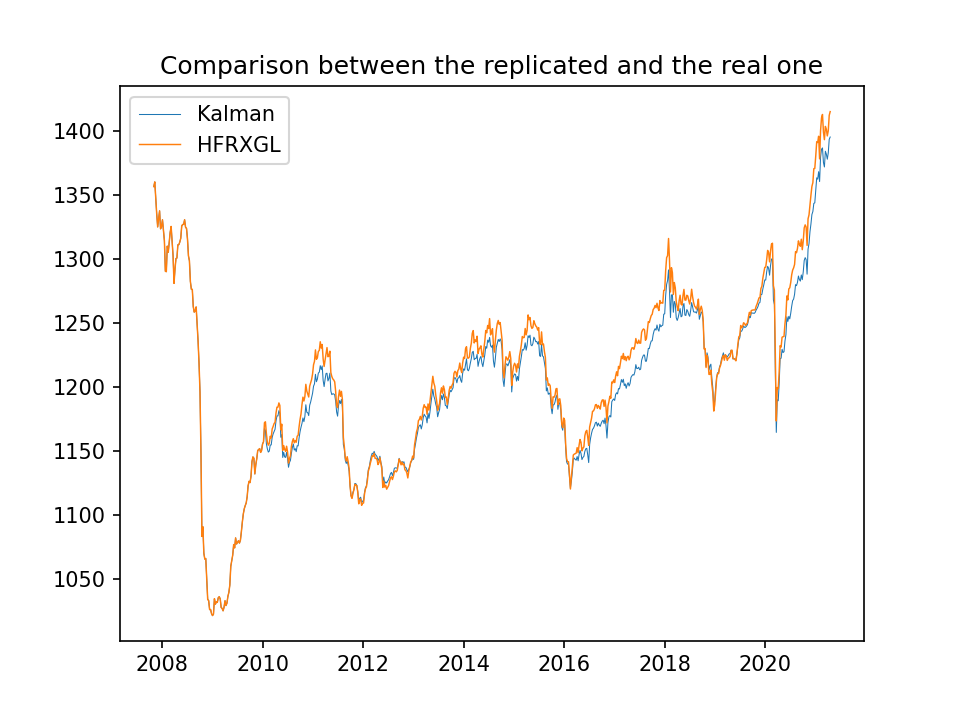

In [4]:
weights_history = pd.DataFrame(weights_history, columns = df.columns, index = df.index)

# calculate the log returns of our replication strategy
log_ret = np.array(0) #inizialization
for index in range(df.shape[0]):
    aux = np.array(weights_history.iloc[index]) #weights at time index
    aux_2 = np.array(df.iloc[index]) #return at time index
    log_ret = np.vstack([log_ret, np.dot(aux,aux_2)]) #log-returns at time index
    
log_ret = log_ret[1:]
weights_history['log_ret'] = log_ret 

%matplotlib notebook

plt.plot(weights_history.index,
         np.exp(weights_history.log_ret.cumsum())*target[0],
         lw = 0.5)
plt.plot(targetR.index, 
         np.exp(targetR['return'].cumsum())*target[0],
         lw = 0.7)

plt.title('Comparison between the replicated and the real one')
plt.legend(['Kalman','HFRXGL'])
plt.show()

## Forecasting approach

After that we tried to find a way to forecast the weights at time $t$ knowing only the returns of the futures,the returns of index and the weights of the replication strategy from the beginning until time $t-1$. In order to make it very simple we hold at time $t+1$ the portfolio's weight predicted for time $t$. Obviously we did not start immediatly but we gave some time to the filter to tune its parameters.

In [5]:
weights_prediction = weights_history.drop(columns = ['log_ret'])
index = weights_prediction.index
log_ret = np.array(0)

trading_cost = 0.0002   #We also track trading costs; fixed cost for trading
trading_cost_strat = 0  #Cumulative costs of the strategy
start = 300             #Start time

#Real behaviour of the filter
for i in range(start):
    log_ret = np.vstack([log_ret, np.dot(weights_prediction.iloc[i],df.iloc[i])])

#Our strategy
for i in range(start, df.shape[0]-1):
    log_ret = np.vstack([log_ret, np.dot(weights_prediction.iloc[i-1],df.iloc[i])])
    #Update costs
    trading_cost_strat += np.dot(trading_cost * np.abs(weights_prediction.iloc[i] - weights_prediction.iloc[i-1]), np.ones(11))

weights_prediction['log_ret'] = log_ret 

#### Visualization of the results

<IPython.core.display.Javascript object>


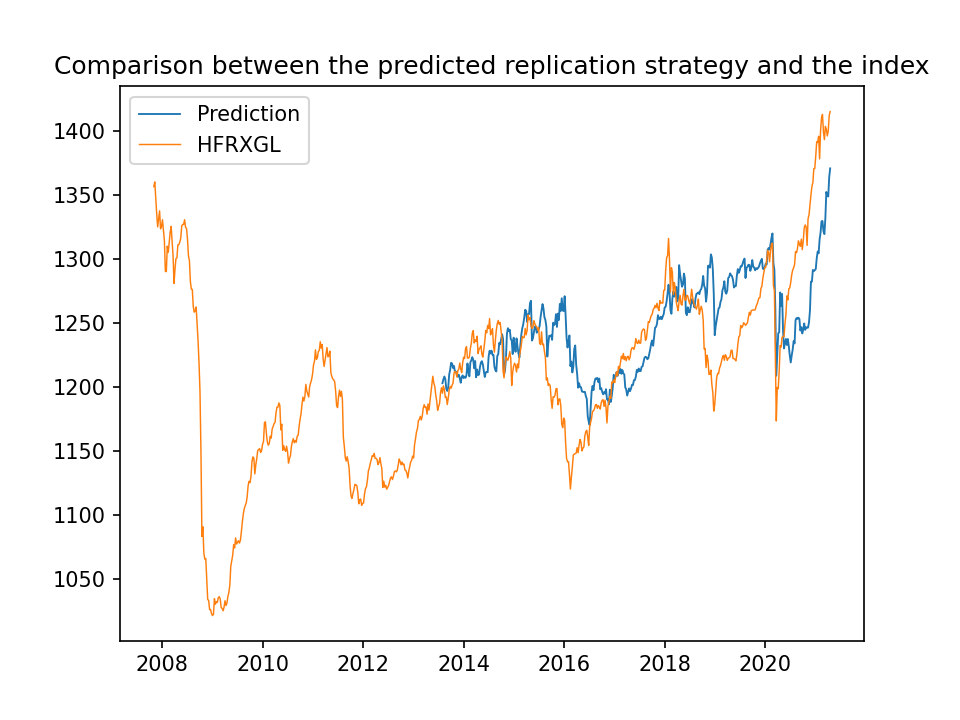

In [6]:
%matplotlib notebook
plt.plot(weights_prediction.iloc[start:].index, 
         np.exp(weights_prediction.iloc[start:].log_ret.cumsum())*target[start],
         lw = 0.9)
plt.plot(targetR.index, 
         np.exp(targetR['return'].cumsum())*target[0],
         lw = 0.7)

plt.title('Comparison between the predicted replication strategy and the index')
plt.legend(['Prediction','HFRXGL'])
plt.show()

Here we can clearly see good results with respect to the real index.

#### Weights of the predicted replication strategy

<IPython.core.display.Javascript object>


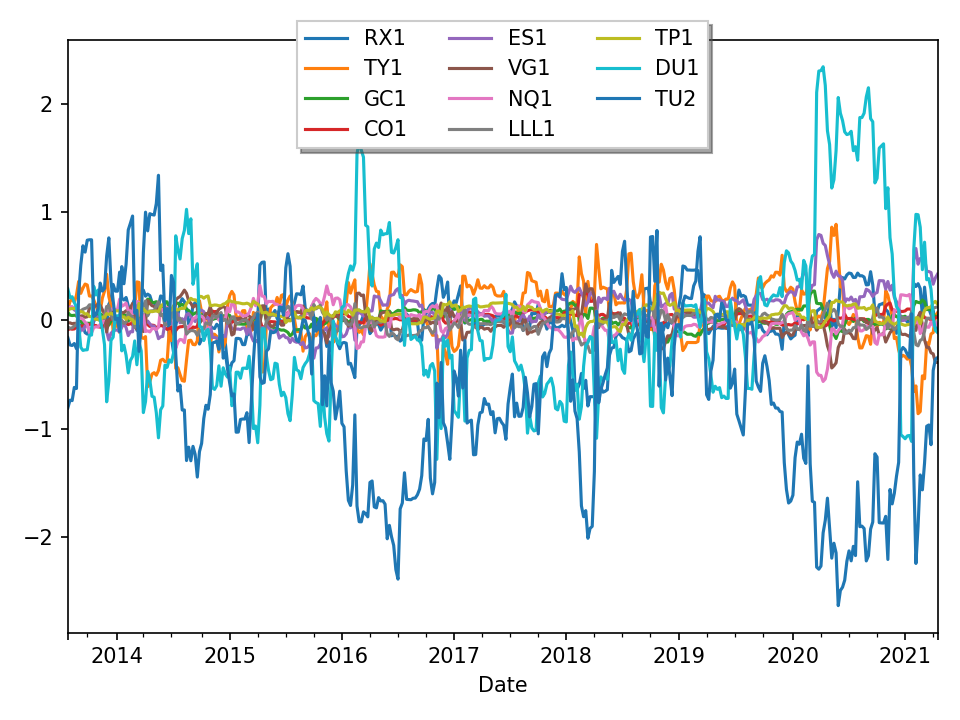

In [7]:
%matplotlib notebook
weights_prediction.iloc[start:].drop(columns = ['log_ret']).plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=False, shadow=True)
plt.tight_layout()
plt.show()

#### Analysis of the strategy

In [8]:
def strat_trading_cost(predictions, trading_cost, df, start):
    # We assume 252 trading days in a year, so 36 trading weeks.
    data = predictions.drop(columns = ['log_ret'])
    costs = abs(data.diff(1).dropna()).sum().sum()*trading_cost
    years_in_consideration = (df.shape[0]-start)/36.
    return costs/years_in_consideration

def volatility_tracking_error(predictions, target, start):
    return np.std(predictions.iloc[start:]['log_ret']-target[start:]['return'])*6

print('The trading cost of the predicted strategy is (per year):', np.round(strat_trading_cost(weights_prediction.iloc[start:],trading_cost, df, start)*100, decimals = 4),'%')

print('The mean volatility tracking error of the predicted strategy is (annualized):',
      np.around(volatility_tracking_error(weights_prediction, targetR, start), decimals = 4))

The trading cost of the predicted strategy is (per year): 0.5346 %
The mean volatility tracking error of the predicted strategy is (annualized): 0.0413


#### Analysis of leverage

<IPython.core.display.Javascript object>


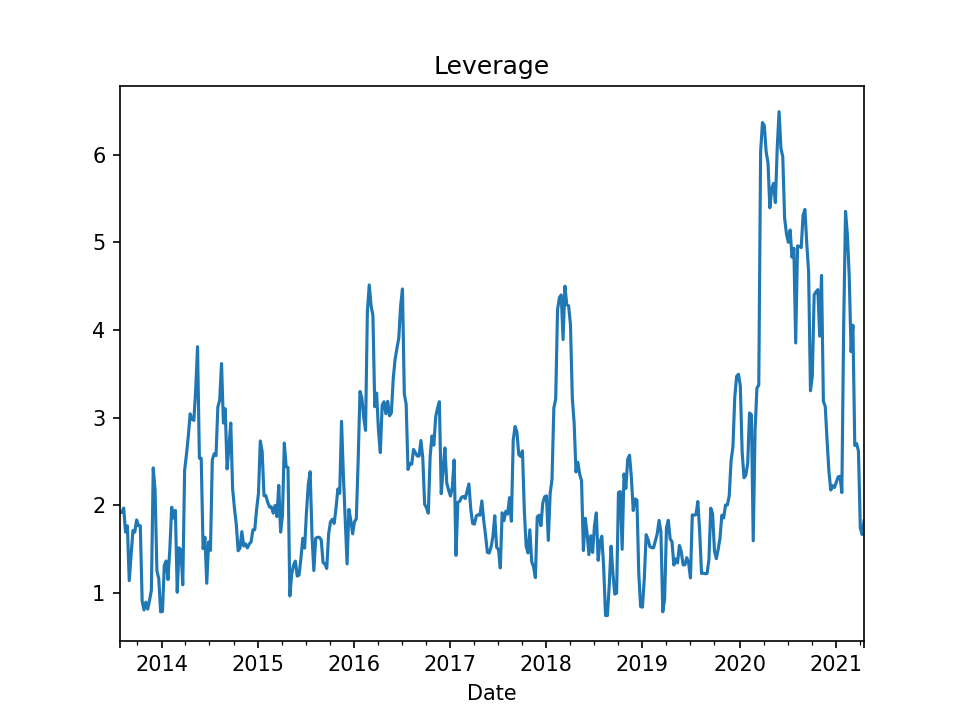

In [9]:
%matplotlib notebook
aux = weights_prediction.iloc[start:].drop(columns = ['log_ret'])
leverage = np.abs(aux).sum(axis = 'columns')
plt.title('Leverage')
leverage.plot()
plt.show()

#We use a lot of leverage!!

### Final comments

The chart of prediction/Index is certainly astonishing, but it wouldn't be if we choose an earlier starting time or another index. Indeed in the slides we present the charts for this two cases and they are a bit delusional. From this we can conclude that Kalman can really work well in prediction but it is too dependant from the initial setting. For this reasons we tried another approach for prediction.